# Random Linear Projections Loss Performance on Classification Tasks

In this notebook we present the performance of the RLP loss proposed in the paper (citation will be added after the reviewing process). We compare RLP to Cross Entropy on a simple synthetic benchmark dataset that is the Moon dataset. We follow that with a study of RLP and Cross Entropy when built with Mixup.

## Training with the Full dataset with some noise:

cuda


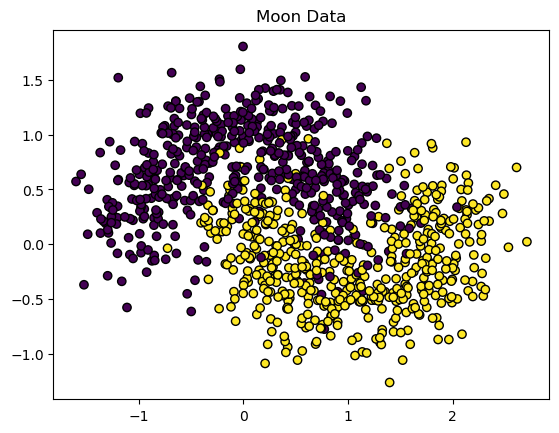

In [27]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import recall_score, f1_score
import torch.nn.functional as F

torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Step 2: Generate and visualize the dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('Moon Data')
plt.show()

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [28]:
def balanced_batch_generator_reg(data, labels, M, K):
    num_samples = len(data)
    selected_batches = set()
    all_indices = np.arange(num_samples)

    # Make sure each data point is in at least one batch
    np.random.shuffle(all_indices)

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)

        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                if i + M > num_samples:  # skip batches smaller than N
                    continue
                selected_batches.add(batch_indices)

            if len(selected_batches) >= K:
                break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]
        
class MoonsClassifier(nn.Module):
    def __init__(self):
        super(MoonsClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.output = nn.Linear(in_features=50, out_features=2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))
        return x

In [29]:
iterations = 5
num_epochs = 50
batch_size = 50
num_batches = 1000

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

y_train_hot = F.one_hot(y_train.long(), num_classes=2).float().to(device)
y_test_hot = F.one_hot(y_test.long(), num_classes=2).float().to(device)

X_train = X_train.to(device); y_train_hot = y_train_hot.to(device);
X_test = X_test.to(device); y_test = y_test.to(device);
criterion_rlp = nn.MSELoss()
criterion_bce = nn.BCELoss()

for i in range(iterations):
    model_bce = MoonsClassifier()
    model_rlp = MoonsClassifier()
    model_bce = model_bce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-3)
    
    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for BCE
        for batch_X, batch_y in train_dataloader:
            optimizer_bce.zero_grad()
            outputs_bce = model_bce(batch_X)
            loss_bce = criterion_bce(outputs_bce, batch_y)
            loss_bce.backward()
            optimizer_bce.step()

        # Training loop for RLP
        for batch_X, batch_y in unique_batches:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            model_rlp.train()
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(batch_X)

            # Reshape batch_X for matrix operations
            batch_X_reshaped = batch_X.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(batch_X_reshaped.transpose(0, 1) @ batch_X_reshaped) @ batch_X_reshaped.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ batch_y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(batch_X_reshaped @ c_pred , batch_X_reshaped @ c)
            loss_rlp.backward()
            optimizer_rlp.step()
            
        # Evaluation for BCE
        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_bce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, BCE Accuracy: {accuracy_bce_array[epoch,i]}, BCE Recall: {recall_bce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

Epoch: 0, BCE Accuracy: 73.0, BCE Recall: 0.6987669527264937
Epoch: 0, RLP Accuracy: 81.0, RLP Recall: 0.8099809980998101
Epoch: 1, BCE Accuracy: 78.0, BCE Recall: 0.7688104245481294
Epoch: 1, RLP Accuracy: 82.0, RLP Recall: 0.8199884792626728
Epoch: 2, BCE Accuracy: 78.8, BCE Recall: 0.7821404495305744
Epoch: 2, RLP Accuracy: 82.19999999999999, RLP Recall: 0.8219651051606114
Epoch: 3, BCE Accuracy: 79.0, BCE Recall: 0.7854261436786542
Epoch: 3, RLP Accuracy: 83.6, RLP Recall: 0.8359343737494997
Epoch: 4, BCE Accuracy: 79.80000000000001, BCE Recall: 0.7949480061231368
Epoch: 4, RLP Accuracy: 85.0, RLP Recall: 0.8498985314072314
Epoch: 5, BCE Accuracy: 81.2, BCE Recall: 0.8103951848445241
Epoch: 5, RLP Accuracy: 86.2, RLP Recall: 0.8618402873722023
Epoch: 6, BCE Accuracy: 80.80000000000001, BCE Recall: 0.806999485331961
Epoch: 6, RLP Accuracy: 88.0, RLP Recall: 0.8797228815190199
Epoch: 7, BCE Accuracy: 81.6, BCE Recall: 0.8154211607601438
Epoch: 7, RLP Accuracy: 88.4, RLP Recall: 0.883

Epoch: 14, BCE Accuracy: 83.6, BCE Recall: 0.8354840780688239
Epoch: 14, RLP Accuracy: 90.0, RLP Recall: 0.8995887153781891
Epoch: 15, BCE Accuracy: 83.39999999999999, BCE Recall: 0.8334396911209309
Epoch: 15, RLP Accuracy: 89.8, RLP Recall: 0.8976063989977474
Epoch: 16, BCE Accuracy: 83.6, BCE Recall: 0.8354074668807707
Epoch: 16, RLP Accuracy: 89.8, RLP Recall: 0.8976063989977474
Epoch: 17, BCE Accuracy: 83.39999999999999, BCE Recall: 0.8334396911209309
Epoch: 17, RLP Accuracy: 89.8, RLP Recall: 0.8976063989977474
Epoch: 18, BCE Accuracy: 84.0, BCE Recall: 0.8393419446051024
Epoch: 18, RLP Accuracy: 90.0, RLP Recall: 0.8996386993175431
Epoch: 19, BCE Accuracy: 83.8, BCE Recall: 0.8372912406442463
Epoch: 19, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8956242472902448
Epoch: 20, BCE Accuracy: 83.8, BCE Recall: 0.8373748689964222
Epoch: 20, RLP Accuracy: 89.8, RLP Recall: 0.8976063989977474
Epoch: 21, BCE Accuracy: 84.0, BCE Recall: 0.839421918908069
Epoch: 21, RLP Accuracy: 89.8, R

Epoch: 29, BCE Accuracy: 86.4, BCE Recall: 0.8635086310718587
Epoch: 29, RLP Accuracy: 89.2, RLP Recall: 0.8914982880841009
Epoch: 30, BCE Accuracy: 86.0, BCE Recall: 0.8590982286634461
Epoch: 30, RLP Accuracy: 89.2, RLP Recall: 0.8914982880841009
Epoch: 31, BCE Accuracy: 86.4, BCE Recall: 0.863033564833465
Epoch: 31, RLP Accuracy: 89.4, RLP Recall: 0.8934780424077983
Epoch: 32, BCE Accuracy: 87.0, BCE Recall: 0.8692842002807373
Epoch: 32, RLP Accuracy: 89.4, RLP Recall: 0.8934780424077983
Epoch: 33, BCE Accuracy: 87.2, BCE Recall: 0.8712563768325849
Epoch: 33, RLP Accuracy: 89.4, RLP Recall: 0.8934780424077983
Epoch: 34, BCE Accuracy: 86.6, BCE Recall: 0.8650015514747069
Epoch: 34, RLP Accuracy: 89.4, RLP Recall: 0.8934780424077983
Epoch: 35, BCE Accuracy: 87.8, BCE Recall: 0.8773992563561452
Epoch: 35, RLP Accuracy: 89.4, RLP Recall: 0.8934780424077983
Epoch: 36, BCE Accuracy: 87.6, BCE Recall: 0.8754239603928566
Epoch: 36, RLP Accuracy: 89.4, RLP Recall: 0.8934780424077983
Epoch: 37

Epoch: 42, BCE Accuracy: 86.6, BCE Recall: 0.8653401668174053
Epoch: 42, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8955722639933166
Epoch: 43, BCE Accuracy: 87.2, BCE Recall: 0.871473555684082
Epoch: 43, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8955722639933166
Epoch: 44, BCE Accuracy: 86.4, BCE Recall: 0.8632913021101388
Epoch: 44, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8955722639933166
Epoch: 45, BCE Accuracy: 87.2, BCE Recall: 0.871473555684082
Epoch: 45, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8955722639933166
Epoch: 46, BCE Accuracy: 87.2, BCE Recall: 0.8714053784700455
Epoch: 46, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8955722639933166
Epoch: 47, BCE Accuracy: 87.2, BCE Recall: 0.8712563768325849
Epoch: 47, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8955722639933166
Epoch: 48, BCE Accuracy: 87.6, BCE Recall: 0.8754900070689544
Epoch: 48, RLP Accuracy: 89.60000000000001, RLP Recall: 0.8955722639933166
Epoch: 49, BCE Accuracy: 87.4, BCE Recall: 

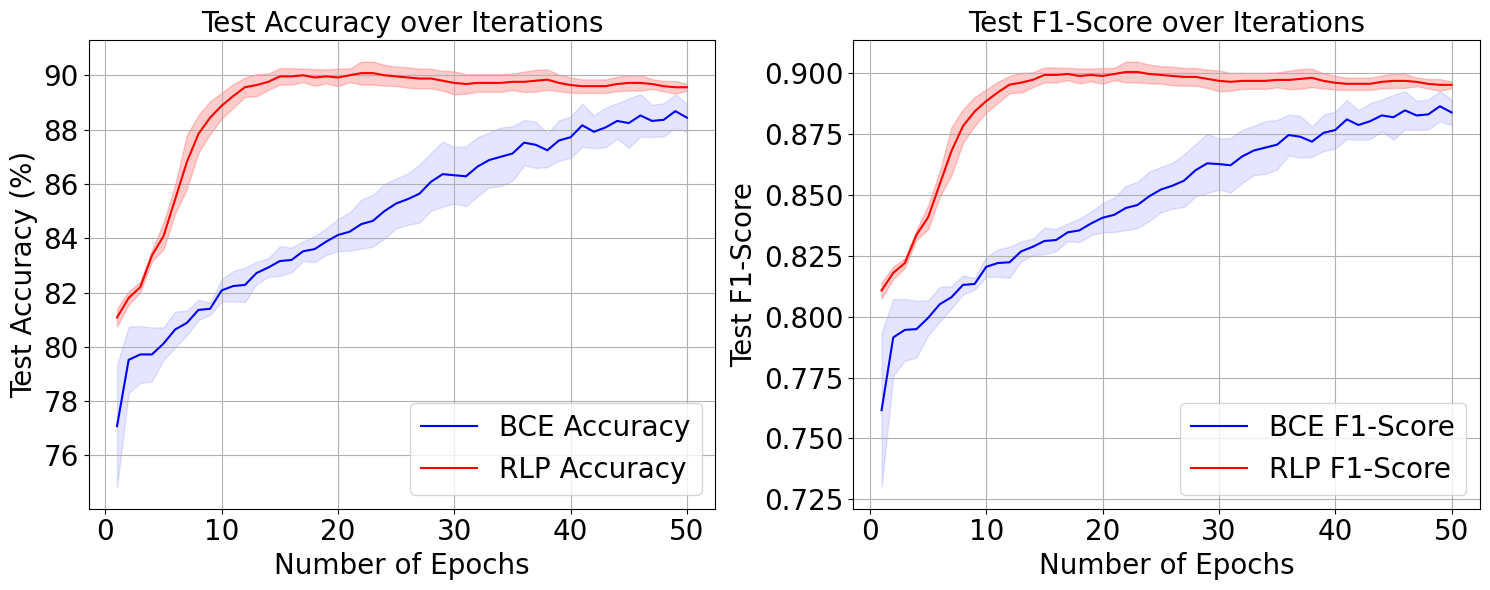

In [30]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
plt.show()

### Add Mixup augmentation

Now, we add mixup and train the augmented data using Cross Entropy Loss. We also use mixup with RLP loss in top of the generated hyperplanes.

In [31]:
iterations = 5
num_epochs = 50
batch_size = 50
num_batches = 1000

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

y_train_hot = F.one_hot(y_train.long(), num_classes=2).float().to(device)
y_test_hot = F.one_hot(y_test.long(), num_classes=2).float().to(device)
criterion_rlp = nn.MSELoss()
criterion_bce = nn.BCELoss()

for i in range(iterations):
    model_bce = MoonsClassifier()
    model_rlp = MoonsClassifier()
    model_bce = model_bce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-3)

    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    train_dataloader_2 = DataLoader(train_dataset, batch_size, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train_hot, batch_size, num_batches))
    unique_batches_2 = list(balanced_batch_generator_reg(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for BCE
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(train_dataloader, train_dataloader_2):
            model_bce.train()
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_bce.zero_grad()
            outputs = model_bce(x)
            loss_bce = criterion_bce(outputs, y)
            loss_bce.backward()
            optimizer_bce.step()

        # Training loop for RLP
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(unique_batches, unique_batches_2):
            model_rlp.train()
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(x)

            # Reshape batch_X for matrix operations
            x = x.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(x.transpose(0, 1) @ x) @ x.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(x @ c_pred, x @ c)
            loss_rlp.backward()
            optimizer_rlp.step()

        # Evaluation for BCE
        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_bce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, BCE Accuracy: {accuracy_bce_array[epoch,i]}, BCE Recall: {recall_bce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

Epoch: 0, BCE Accuracy: 47.0, BCE Recall: 0.31972789115646255
Epoch: 0, RLP Accuracy: 82.0, RLP Recall: 0.8197664172767907
Epoch: 1, BCE Accuracy: 68.8, BCE Recall: 0.6715180917727915
Epoch: 1, RLP Accuracy: 83.39999999999999, RLP Recall: 0.833182594714099
Epoch: 2, BCE Accuracy: 74.6, BCE Recall: 0.7410689164447742
Epoch: 2, RLP Accuracy: 84.2, RLP Recall: 0.8413087408752526
Epoch: 3, BCE Accuracy: 76.8, BCE Recall: 0.7671617824167001
Epoch: 3, RLP Accuracy: 85.39999999999999, RLP Recall: 0.853436610330109
Epoch: 4, BCE Accuracy: 77.8, BCE Recall: 0.777999111996448
Epoch: 4, RLP Accuracy: 86.0, RLP Recall: 0.8592704580545547
Epoch: 5, BCE Accuracy: 78.8, BCE Recall: 0.7879457141028103
Epoch: 5, RLP Accuracy: 87.2, RLP Recall: 0.8707070707070707
Epoch: 6, BCE Accuracy: 80.0, BCE Recall: 0.7995381358650331
Epoch: 6, RLP Accuracy: 87.6, RLP Recall: 0.874424784496727
Epoch: 7, BCE Accuracy: 80.0, BCE Recall: 0.7997404636408785
Epoch: 7, RLP Accuracy: 88.4, RLP Recall: 0.8827316252587991
E

Epoch: 15, BCE Accuracy: 83.2, BCE Recall: 0.831544496318044
Epoch: 15, RLP Accuracy: 88.8, RLP Recall: 0.8862509953037911
Epoch: 16, BCE Accuracy: 82.8, BCE Recall: 0.8276027968439283
Epoch: 16, RLP Accuracy: 88.6, RLP Recall: 0.8844989483325296
Epoch: 17, BCE Accuracy: 83.0, BCE Recall: 0.8296395172184343
Epoch: 17, RLP Accuracy: 88.8, RLP Recall: 0.8862509953037911
Epoch: 18, BCE Accuracy: 83.2, BCE Recall: 0.8313930148534725
Epoch: 18, RLP Accuracy: 89.0, RLP Recall: 0.8885516168120899
Epoch: 19, BCE Accuracy: 84.0, BCE Recall: 0.8392567230875568
Epoch: 19, RLP Accuracy: 89.2, RLP Recall: 0.8907254213142088
Epoch: 20, BCE Accuracy: 83.8, BCE Recall: 0.8373748689964222
Epoch: 20, RLP Accuracy: 88.4, RLP Recall: 0.8823051948051948
Epoch: 21, BCE Accuracy: 83.8, BCE Recall: 0.8373748689964222
Epoch: 21, RLP Accuracy: 88.8, RLP Recall: 0.8865772247067212
Epoch: 22, BCE Accuracy: 84.2, BCE Recall: 0.8412219877399256
Epoch: 22, RLP Accuracy: 88.8, RLP Recall: 0.8862509953037911
Epoch: 23

Epoch: 30, BCE Accuracy: 86.2, BCE Recall: 0.8613962420302839
Epoch: 30, RLP Accuracy: 89.2, RLP Recall: 0.890422077922078
Epoch: 31, BCE Accuracy: 86.2, BCE Recall: 0.8616541353383458
Epoch: 31, RLP Accuracy: 89.0, RLP Recall: 0.8885516168120899
Epoch: 32, BCE Accuracy: 86.4, BCE Recall: 0.8636312589241308
Epoch: 32, RLP Accuracy: 89.0, RLP Recall: 0.8884467323005529
Epoch: 33, BCE Accuracy: 86.2, BCE Recall: 0.8610658064827903
Epoch: 33, RLP Accuracy: 89.0, RLP Recall: 0.8885516168120899
Epoch: 34, BCE Accuracy: 86.6, BCE Recall: 0.8654829163303739
Epoch: 34, RLP Accuracy: 88.8, RLP Recall: 0.8864723722408732
Epoch: 35, BCE Accuracy: 86.6, BCE Recall: 0.8654829163303739
Epoch: 35, RLP Accuracy: 89.0, RLP Recall: 0.8885516168120899
Epoch: 36, BCE Accuracy: 86.6, BCE Recall: 0.8654829163303739
Epoch: 36, RLP Accuracy: 89.0, RLP Recall: 0.8884467323005529
Epoch: 37, BCE Accuracy: 87.0, BCE Recall: 0.8695612038898857
Epoch: 37, RLP Accuracy: 89.0, RLP Recall: 0.8885516168120899
Epoch: 38

Epoch: 46, BCE Accuracy: 86.8, BCE Recall: 0.8674571042992096
Epoch: 46, RLP Accuracy: 88.6, RLP Recall: 0.8848014745411259
Epoch: 47, BCE Accuracy: 87.0, BCE Recall: 0.8694312424922963
Epoch: 47, RLP Accuracy: 88.2, RLP Recall: 0.8806590854845039
Epoch: 48, BCE Accuracy: 87.2, BCE Recall: 0.8715375351264553
Epoch: 48, RLP Accuracy: 88.2, RLP Recall: 0.8806590854845039
Epoch: 49, BCE Accuracy: 87.4, BCE Recall: 0.8736842105263158
Epoch: 49, RLP Accuracy: 88.0, RLP Recall: 0.8784755979000584
Epoch: 0, BCE Accuracy: 73.0, BCE Recall: 0.7285133390446081
Epoch: 0, RLP Accuracy: 82.0, RLP Recall: 0.8197664172767907
Epoch: 1, BCE Accuracy: 76.4, BCE Recall: 0.7624798711755234
Epoch: 1, RLP Accuracy: 82.6, RLP Recall: 0.8257986232084289
Epoch: 2, BCE Accuracy: 78.2, BCE Recall: 0.7813624529126934
Epoch: 2, RLP Accuracy: 83.39999999999999, RLP Recall: 0.8336479991662358
Epoch: 3, BCE Accuracy: 78.60000000000001, BCE Recall: 0.7853741510243871
Epoch: 3, RLP Accuracy: 85.0, RLP Recall: 0.8494936

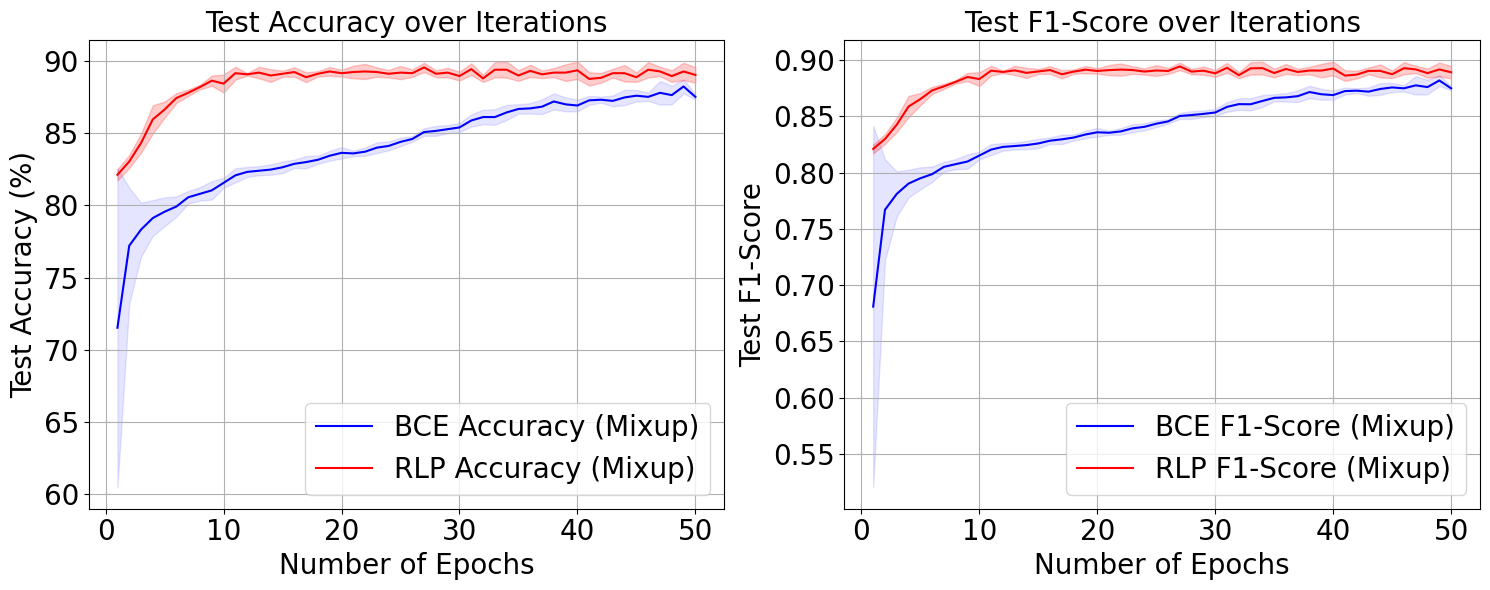

In [32]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy (Mixup)", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score (Mixup)", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
#plt.savefig("moons_rlp_bce.pdf", format="pdf", dpi=600)
plt.show()

# The Scarce Data Regime

In this section, we will repeat the same experiments using only $25$ training data points. We also only use 10 batches to train RLP.

In [20]:
X, y = make_moons(n_samples=500, noise=0.1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [21]:
iterations = 5
num_epochs = 200
batch_size = 3
num_batches = 100

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

y_train_hot = F.one_hot(y_train.long(), num_classes=2).float().to(device)
y_test_hot = F.one_hot(y_test.long(), num_classes=2).float().to(device)

X_train = X_train.to(device); y_train_hot = y_train_hot.to(device);
X_test = X_test.to(device); y_test = y_test.to(device);
criterion_rlp = nn.MSELoss()
criterion_bce = nn.BCELoss()

for i in range(iterations):
    model_bce = MoonsClassifier()
    model_rlp = MoonsClassifier()
    model_bce = model_bce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-3)
    
    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for BCE
        for batch_X, batch_y in train_dataloader:
            optimizer_bce.zero_grad()
            outputs_bce = model_bce(batch_X)
            loss_bce = criterion_bce(outputs_bce, batch_y)
            loss_bce.backward()
            optimizer_bce.step()

        # Training loop for RLP
        for batch_X, batch_y in unique_batches:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            model_rlp.train()
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(batch_X)

            # Reshape batch_X for matrix operations
            batch_X_reshaped = batch_X.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(batch_X_reshaped.transpose(0, 1) @ batch_X_reshaped) @ batch_X_reshaped.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ batch_y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(batch_X_reshaped @ c_pred , batch_X_reshaped @ c)
            loss_rlp.backward()
            optimizer_rlp.step()
            
        # Evaluation for BCE
        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_bce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, BCE Accuracy: {accuracy_bce_array[epoch,i]}, BCE Recall: {recall_bce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

Epoch: 0, BCE Accuracy: 74.73684210526315, BCE Recall: 0.7372981343558734
Epoch: 0, RLP Accuracy: 85.26315789473684, RLP Recall: 0.8504784688995215
Epoch: 1, BCE Accuracy: 77.89473684210526, BCE Recall: 0.7784721574479992
Epoch: 1, RLP Accuracy: 86.52631578947368, RLP Recall: 0.8636917999856517
Epoch: 2, BCE Accuracy: 80.0, BCE Recall: 0.7999680835501731
Epoch: 2, RLP Accuracy: 87.1578947368421, RLP Recall: 0.8701400560224091
Epoch: 3, BCE Accuracy: 80.42105263157895, BCE Recall: 0.8042105263157895
Epoch: 3, RLP Accuracy: 88.0, RLP Recall: 0.8788639383648981
Epoch: 4, BCE Accuracy: 81.26315789473684, BCE Recall: 0.8126016782733201
Epoch: 4, RLP Accuracy: 88.8421052631579, RLP Recall: 0.8875418228275582
Epoch: 5, BCE Accuracy: 81.89473684210526, BCE Recall: 0.8189080398623967
Epoch: 5, RLP Accuracy: 89.6842105263158, RLP Recall: 0.8961776421730655
Epoch: 6, BCE Accuracy: 81.89473684210526, BCE Recall: 0.8189273049645389
Epoch: 6, RLP Accuracy: 89.89473684210526, RLP Recall: 0.8982615214

Epoch: 56, BCE Accuracy: 93.89473684210526, BCE Recall: 0.9388942860057934
Epoch: 56, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 57, BCE Accuracy: 93.89473684210526, BCE Recall: 0.9388942860057934
Epoch: 57, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 58, BCE Accuracy: 93.89473684210526, BCE Recall: 0.9389083780895063
Epoch: 58, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 59, BCE Accuracy: 94.10526315789474, BCE Recall: 0.9410084451068057
Epoch: 59, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 60, BCE Accuracy: 94.10526315789474, BCE Recall: 0.9410084451068057
Epoch: 60, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 61, BCE Accuracy: 94.10526315789474, BCE Recall: 0.9410084451068057
Epoch: 61, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 62, BCE Accuracy: 94.3157894736842, BCE Recall: 0.9431326903890921
Epoch: 62, RLP Accuracy: 9

Epoch: 112, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 112, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 113, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 113, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 114, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 114, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 115, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 115, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 116, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 116, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 117, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 117, RLP Accuracy: 97.68421052631578, RLP Recall: 0.9768384096742306
Epoch: 118, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 118, 

Epoch: 168, BCE Accuracy: 97.26315789473684, BCE Recall: 0.9726272114331816
Epoch: 168, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 169, BCE Accuracy: 97.26315789473684, BCE Recall: 0.9726272114331816
Epoch: 169, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 170, BCE Accuracy: 97.26315789473684, BCE Recall: 0.9726272114331816
Epoch: 170, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 171, BCE Accuracy: 97.26315789473684, BCE Recall: 0.9726272114331816
Epoch: 171, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 172, BCE Accuracy: 97.26315789473684, BCE Recall: 0.9726272114331816
Epoch: 172, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 173, BCE Accuracy: 97.26315789473684, BCE Recall: 0.9726272114331816
Epoch: 173, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 174, BCE Accuracy: 97.26315789473684, BCE Recall: 0.9726272114331816
Epoch: 174, RLP Ac

Epoch: 24, BCE Accuracy: 87.57894736842105, BCE Recall: 0.8755688755688755
Epoch: 24, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 25, BCE Accuracy: 88.42105263157895, BCE Recall: 0.884004884004884
Epoch: 25, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 26, BCE Accuracy: 88.21052631578948, BCE Recall: 0.8819163292847503
Epoch: 26, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 27, BCE Accuracy: 88.63157894736841, BCE Recall: 0.8860931504902657
Epoch: 27, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 28, BCE Accuracy: 88.42105263157895, BCE Recall: 0.884004884004884
Epoch: 28, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 29, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8882943084452608
Epoch: 29, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 30, BCE Accuracy: 89.26315789473685, BCE Recall: 0.892509617560534
Epoch: 30, RLP Accuracy: 97.8947368

Epoch: 80, BCE Accuracy: 96.21052631578947, BCE Recall: 0.962091653956656
Epoch: 80, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 81, BCE Accuracy: 95.78947368421052, BCE Recall: 0.9578721441748261
Epoch: 81, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 82, BCE Accuracy: 96.0, BCE Recall: 0.9599822636071389
Epoch: 82, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 83, BCE Accuracy: 95.78947368421052, BCE Recall: 0.9578721441748261
Epoch: 83, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 84, BCE Accuracy: 96.42105263157895, BCE Recall: 0.964200371518126
Epoch: 84, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 85, BCE Accuracy: 96.63157894736842, BCE Recall: 0.9663120567375887
Epoch: 85, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 86, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 86, RLP Accuracy: 98.105263157894

Epoch: 136, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 136, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 137, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 137, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 138, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 138, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 139, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 139, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 140, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 140, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 141, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768404629247947
Epoch: 141, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 142, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 142, RLP Ac

Epoch: 192, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 192, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 193, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 193, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 194, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 194, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 195, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 195, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 196, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 196, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 197, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 197, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 198, BCE Accuracy: 97.89473684210527, BCE Recall: 0.978945035460993
Epoch: 198, RLP Acc

Epoch: 48, BCE Accuracy: 92.84210526315789, BCE Recall: 0.9283496007098492
Epoch: 48, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 49, BCE Accuracy: 93.47368421052632, BCE Recall: 0.9346951627853345
Epoch: 49, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 50, BCE Accuracy: 93.47368421052632, BCE Recall: 0.9346951627853345
Epoch: 50, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 51, BCE Accuracy: 93.6842105263158, BCE Recall: 0.9367947626144347
Epoch: 51, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 52, BCE Accuracy: 93.6842105263158, BCE Recall: 0.9367947626144347
Epoch: 52, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 53, BCE Accuracy: 93.6842105263158, BCE Recall: 0.9367947626144347
Epoch: 53, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 54, BCE Accuracy: 94.10526315789474, BCE Recall: 0.9410210018447567
Epoch: 54, RLP Accuracy: 97.894736

Epoch: 104, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 104, RLP Accuracy: 98.3157894736842, RLP Recall: 0.9831560283687943
Epoch: 105, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 105, RLP Accuracy: 98.3157894736842, RLP Recall: 0.9831560283687943
Epoch: 106, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 106, RLP Accuracy: 98.3157894736842, RLP Recall: 0.9831560283687943
Epoch: 107, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 107, RLP Accuracy: 98.3157894736842, RLP Recall: 0.9831560283687943
Epoch: 108, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 108, RLP Accuracy: 98.3157894736842, RLP Recall: 0.9831560283687943
Epoch: 109, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 109, RLP Accuracy: 98.3157894736842, RLP Recall: 0.9831560283687943
Epoch: 110, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 110, RLP Ac

Epoch: 160, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 160, RLP Accuracy: 98.52631578947368, RLP Recall: 0.9852621127703238
Epoch: 161, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 161, RLP Accuracy: 98.52631578947368, RLP Recall: 0.9852621127703238
Epoch: 162, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 162, RLP Accuracy: 98.52631578947368, RLP Recall: 0.9852621127703238
Epoch: 163, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 163, RLP Accuracy: 98.52631578947368, RLP Recall: 0.9852621127703238
Epoch: 164, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 164, RLP Accuracy: 98.52631578947368, RLP Recall: 0.9852621127703238
Epoch: 165, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 165, RLP Accuracy: 98.52631578947368, RLP Recall: 0.9852621127703238
Epoch: 166, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705230496453902
Epoch: 166, 

Epoch: 16, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8566992014196984
Epoch: 16, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705230496453902
Epoch: 17, BCE Accuracy: 85.89473684210527, BCE Recall: 0.8588247297375227
Epoch: 17, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705230496453902
Epoch: 18, BCE Accuracy: 86.31578947368422, BCE Recall: 0.8629611053657108
Epoch: 18, RLP Accuracy: 97.26315789473684, RLP Recall: 0.9726272114331816
Epoch: 19, BCE Accuracy: 86.94736842105263, BCE Recall: 0.8693433895297249
Epoch: 19, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 20, BCE Accuracy: 86.94736842105263, BCE Recall: 0.8693062803990486
Epoch: 20, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 21, BCE Accuracy: 87.36842105263159, BCE Recall: 0.8734817813765181
Epoch: 21, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 22, BCE Accuracy: 87.1578947368421, BCE Recall: 0.8714672912535655
Epoch: 22, RLP Accuracy: 9

Epoch: 72, BCE Accuracy: 95.15789473684211, BCE Recall: 0.9515712202279366
Epoch: 72, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 73, BCE Accuracy: 95.57894736842105, BCE Recall: 0.9557769295223909
Epoch: 73, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 74, BCE Accuracy: 95.57894736842105, BCE Recall: 0.9557769295223909
Epoch: 74, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 75, BCE Accuracy: 95.57894736842105, BCE Recall: 0.9557769295223909
Epoch: 75, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 76, BCE Accuracy: 95.36842105263158, BCE Recall: 0.953674149732241
Epoch: 76, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 77, BCE Accuracy: 96.0, BCE Recall: 0.9599822636071389
Epoch: 77, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 78, BCE Accuracy: 95.57894736842105, BCE Recall: 0.9557769295223909
Epoch: 78, RLP Accuracy: 97.89473684210527, R

Epoch: 128, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 128, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 129, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 129, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 130, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 130, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 131, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 131, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 132, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 132, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 133, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 133, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 134, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 134, 

Epoch: 183, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768384096742306
Epoch: 183, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 184, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768384096742306
Epoch: 184, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 185, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 185, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 186, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 186, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 187, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 187, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 188, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 188, RLP Accuracy: 98.10526315789474, RLP Recall: 0.9810496079152795
Epoch: 189, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 189, 

Epoch: 39, BCE Accuracy: 93.6842105263158, BCE Recall: 0.9367947626144347
Epoch: 39, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 40, BCE Accuracy: 93.6842105263158, BCE Recall: 0.9367947626144347
Epoch: 40, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 41, BCE Accuracy: 93.05263157894737, BCE Recall: 0.9304264073395148
Epoch: 41, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 42, BCE Accuracy: 93.05263157894737, BCE Recall: 0.9304264073395148
Epoch: 42, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 43, BCE Accuracy: 93.05263157894737, BCE Recall: 0.9304264073395148
Epoch: 43, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 44, BCE Accuracy: 93.05263157894737, BCE Recall: 0.9304473995979927
Epoch: 44, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 45, BCE Accuracy: 93.26315789473684, BCE Recall: 0.9325643300798581
Epoch: 45, RLP Accuracy: 97

Epoch: 95, BCE Accuracy: 96.63157894736842, BCE Recall: 0.9662977153398609
Epoch: 95, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 96, BCE Accuracy: 96.42105263157895, BCE Recall: 0.9641946569116506
Epoch: 96, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 97, BCE Accuracy: 96.63157894736842, BCE Recall: 0.966308472532539
Epoch: 97, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 98, BCE Accuracy: 96.63157894736842, BCE Recall: 0.966308472532539
Epoch: 98, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 99, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684160131921326
Epoch: 99, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 100, BCE Accuracy: 96.84210526315789, BCE Recall: 0.9684120925159935
Epoch: 100, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 101, BCE Accuracy: 97.05263157894737, BCE Recall: 0.9705157308551768
Epoch: 101, RLP Accuracy: 97.8

Epoch: 151, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768384096742306
Epoch: 151, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 152, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768384096742306
Epoch: 152, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 153, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768384096742306
Epoch: 153, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 154, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 154, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 155, BCE Accuracy: 97.47368421052632, BCE Recall: 0.9747340425531914
Epoch: 155, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 156, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768384096742306
Epoch: 156, RLP Accuracy: 97.89473684210527, RLP Recall: 0.978945035460993
Epoch: 157, BCE Accuracy: 97.68421052631578, BCE Recall: 0.9768384096742306
Epoch: 157, RLP Ac

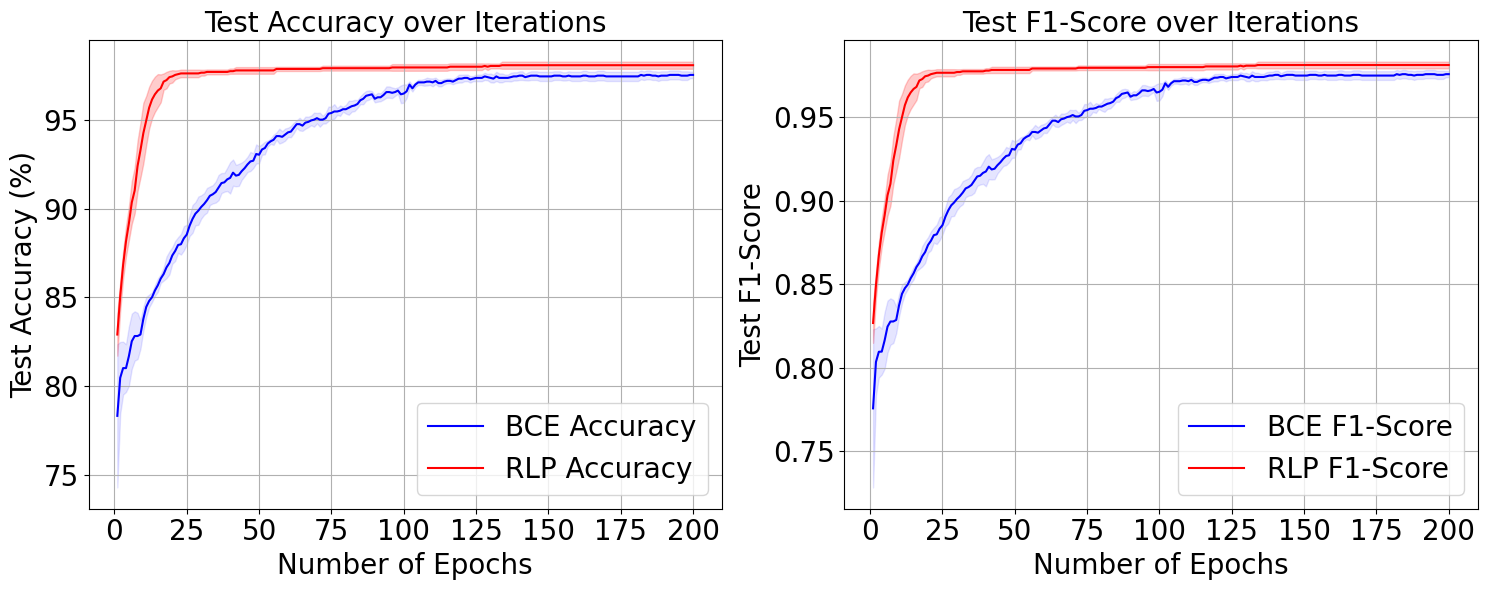

In [22]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
plt.show()

### Mixup on top in the Small Data regime

In [23]:
iterations = 5
num_epochs = 200
batch_size = 3
num_batches = 100

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

y_train_hot = F.one_hot(y_train.long(), num_classes=2).float().to(device)
y_test_hot = F.one_hot(y_test.long(), num_classes=2).float().to(device)
criterion_rlp = nn.MSELoss()
criterion_bce = nn.BCELoss()

for i in range(iterations):
    model_bce = MoonsClassifier()
    model_rlp = MoonsClassifier()
    model_bce = model_bce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_bce = optim.AdamW(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.AdamW(model_rlp.parameters(), lr=1e-3)

    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    train_dataloader_2 = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train_hot, batch_size, num_batches))
    unique_batches_2 = list(balanced_batch_generator_reg(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for BCE
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(train_dataloader, train_dataloader_2):
            model_bce.train()
            alpha = 0.4
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_bce.zero_grad()
            outputs = model_bce(x)
            loss_bce = criterion_bce(outputs, y)
            loss_bce.backward()
            optimizer_bce.step()

        # Training loop for RLP
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(unique_batches, unique_batches_2):
            model_rlp.train()
            alpha = 0.4
            lam = np.random.beta(alpha, alpha)
            
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(x)

            # Reshape batch_X for matrix operations
            x = x.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(x.transpose(0, 1) @ x) @ x.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(x @ c_pred, x @ c)
            loss_rlp.backward()
            optimizer_rlp.step()

        # Evaluation for BCE
        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_bce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, BCE Accuracy: {accuracy_bce_array[epoch,i]}, BCE Recall: {recall_bce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

Epoch: 0, BCE Accuracy: 73.47368421052632, BCE Recall: 0.715
Epoch: 0, RLP Accuracy: 81.05263157894737, RLP Recall: 0.8077580314422421
Epoch: 1, BCE Accuracy: 74.94736842105263, BCE Recall: 0.7368592563626291
Epoch: 1, RLP Accuracy: 83.15789473684211, RLP Recall: 0.8301873301873302
Epoch: 2, BCE Accuracy: 76.0, BCE Recall: 0.7524412991002853
Epoch: 2, RLP Accuracy: 85.47368421052632, RLP Recall: 0.8532381638986034
Epoch: 3, BCE Accuracy: 77.05263157894737, BCE Recall: 0.7670531492254602
Epoch: 3, RLP Accuracy: 87.1578947368421, RLP Recall: 0.8705670036317179
Epoch: 4, BCE Accuracy: 76.42105263157895, BCE Recall: 0.7622622622622623
Epoch: 4, RLP Accuracy: 88.0, RLP Recall: 0.879692866886767
Epoch: 5, BCE Accuracy: 76.0, BCE Recall: 0.7586898395721926
Epoch: 5, RLP Accuracy: 89.47368421052632, RLP Recall: 0.8945681511470986
Epoch: 6, BCE Accuracy: 76.63157894736841, BCE Recall: 0.765813423587885
Epoch: 6, RLP Accuracy: 90.73684210526316, RLP Recall: 0.9070218520891167
Epoch: 7, BCE Accur

Epoch: 58, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8243632751070304
Epoch: 58, RLP Accuracy: 95.57894736842105, RLP Recall: 0.9557392542896316
Epoch: 59, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8243632751070304
Epoch: 59, RLP Accuracy: 94.73684210526315, RLP Recall: 0.9472749472749473
Epoch: 60, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8243632751070304
Epoch: 60, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9641946569116506
Epoch: 61, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8243632751070304
Epoch: 61, RLP Accuracy: 95.36842105263158, RLP Recall: 0.9536379769299024
Epoch: 62, BCE Accuracy: 82.73684210526315, BCE Recall: 0.8265311575872021
Epoch: 62, RLP Accuracy: 96.0, RLP Recall: 0.9599744546103661
Epoch: 63, BCE Accuracy: 82.73684210526315, BCE Recall: 0.8265311575872021
Epoch: 63, RLP Accuracy: 95.57894736842105, RLP Recall: 0.9557510346938503
Epoch: 64, BCE Accuracy: 82.94736842105263, BCE Recall: 0.8286962212991038
Epoch: 64, RLP Accuracy: 95.3684210526

Epoch: 114, BCE Accuracy: 87.1578947368421, BCE Recall: 0.871302872422171
Epoch: 114, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684070502161622
Epoch: 115, BCE Accuracy: 87.36842105263159, BCE Recall: 0.873387354728649
Epoch: 115, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684070502161622
Epoch: 116, BCE Accuracy: 87.36842105263159, BCE Recall: 0.873387354728649
Epoch: 116, RLP Accuracy: 96.21052631578947, RLP Recall: 0.9620768575686609
Epoch: 117, BCE Accuracy: 87.36842105263159, BCE Recall: 0.873387354728649
Epoch: 117, RLP Accuracy: 94.94736842105263, RLP Recall: 0.9493927125506073
Epoch: 118, BCE Accuracy: 87.36842105263159, BCE Recall: 0.873387354728649
Epoch: 118, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684120925159935
Epoch: 119, BCE Accuracy: 87.57894736842105, BCE Recall: 0.8754715639705131
Epoch: 119, RLP Accuracy: 96.63157894736842, RLP Recall: 0.9663036924059163
Epoch: 120, BCE Accuracy: 87.57894736842105, BCE Recall: 0.8754715639705131
Epoch: 120, RLP Ac

Epoch: 170, BCE Accuracy: 89.89473684210526, BCE Recall: 0.8988177654702311
Epoch: 170, RLP Accuracy: 94.73684210526315, RLP Recall: 0.9473086360590852
Epoch: 171, BCE Accuracy: 89.89473684210526, BCE Recall: 0.8988177654702311
Epoch: 171, RLP Accuracy: 93.47368421052632, RLP Recall: 0.934540718118329
Epoch: 172, BCE Accuracy: 89.89473684210526, BCE Recall: 0.8988177654702311
Epoch: 172, RLP Accuracy: 93.89473684210526, RLP Recall: 0.9387911077143198
Epoch: 173, BCE Accuracy: 89.89473684210526, BCE Recall: 0.8988177654702311
Epoch: 173, RLP Accuracy: 95.15789473684211, RLP Recall: 0.9515093142063283
Epoch: 174, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009103377259755
Epoch: 174, RLP Accuracy: 94.73684210526315, RLP Recall: 0.9473086360590852
Epoch: 175, BCE Accuracy: 90.31578947368422, BCE Recall: 0.9030026990553307
Epoch: 175, RLP Accuracy: 93.89473684210526, RLP Recall: 0.9387911077143198
Epoch: 176, BCE Accuracy: 90.31578947368422, BCE Recall: 0.9030026990553307
Epoch: 176, R

Epoch: 26, BCE Accuracy: 82.3157894736842, BCE Recall: 0.8231382978723404
Epoch: 26, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705199134659716
Epoch: 27, BCE Accuracy: 82.3157894736842, BCE Recall: 0.8231508403659314
Epoch: 27, RLP Accuracy: 96.21052631578947, RLP Recall: 0.9620768575686609
Epoch: 28, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8252600600121442
Epoch: 28, RLP Accuracy: 97.26315789473684, RLP Recall: 0.972623813513861
Epoch: 29, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8252631578947368
Epoch: 29, RLP Accuracy: 96.21052631578947, RLP Recall: 0.9620849297573435
Epoch: 30, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8252631578947368
Epoch: 30, RLP Accuracy: 95.78947368421052, RLP Recall: 0.9578527062999114
Epoch: 31, BCE Accuracy: 82.3157894736842, BCE Recall: 0.823157110945644
Epoch: 31, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9641876699145382
Epoch: 32, BCE Accuracy: 82.52631578947368, BCE Recall: 0.8252600600121442
Epoch: 32, RLP Accuracy: 96.42

Epoch: 82, BCE Accuracy: 85.47368421052632, BCE Recall: 0.8543003080698293
Epoch: 82, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747313543994042
Epoch: 83, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8564444444444446
Epoch: 83, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705157308551768
Epoch: 84, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8564444444444446
Epoch: 84, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684070502161622
Epoch: 85, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8564444444444446
Epoch: 85, RLP Accuracy: 96.63157894736842, RLP Recall: 0.9662977153398609
Epoch: 86, BCE Accuracy: 86.10526315789474, BCE Recall: 0.8606666666666667
Epoch: 86, RLP Accuracy: 96.0, RLP Recall: 0.9599652218658645
Epoch: 87, BCE Accuracy: 86.10526315789474, BCE Recall: 0.8606666666666667
Epoch: 87, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705157308551768
Epoch: 88, BCE Accuracy: 86.10526315789474, BCE Recall: 0.8606666666666667
Epoch: 88, RLP Accuracy: 95.5789473684

Epoch: 138, BCE Accuracy: 88.0, BCE Recall: 0.8797868797868797
Epoch: 138, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9641946569116506
Epoch: 139, BCE Accuracy: 88.21052631578948, BCE Recall: 0.8819163292847503
Epoch: 139, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705199134659716
Epoch: 140, BCE Accuracy: 88.21052631578948, BCE Recall: 0.8819163292847503
Epoch: 140, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684070502161622
Epoch: 141, BCE Accuracy: 88.42105263157895, BCE Recall: 0.8840440122325245
Epoch: 141, RLP Accuracy: 95.57894736842105, RLP Recall: 0.9557392542896316
Epoch: 142, BCE Accuracy: 88.42105263157895, BCE Recall: 0.8840440122325245
Epoch: 142, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684120925159935
Epoch: 143, BCE Accuracy: 88.42105263157895, BCE Recall: 0.8840440122325245
Epoch: 143, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684120925159935
Epoch: 144, BCE Accuracy: 88.21052631578948, BCE Recall: 0.8819163292847503
Epoch: 144, RLP Accuracy:

Epoch: 194, BCE Accuracy: 90.31578947368422, BCE Recall: 0.9030026990553307
Epoch: 194, RLP Accuracy: 95.78947368421052, RLP Recall: 0.9578721441748261
Epoch: 195, BCE Accuracy: 90.31578947368422, BCE Recall: 0.9030026990553307
Epoch: 195, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966308472532539
Epoch: 196, BCE Accuracy: 90.31578947368422, BCE Recall: 0.9030026990553307
Epoch: 196, RLP Accuracy: 94.94736842105263, RLP Recall: 0.9494232475598936
Epoch: 197, BCE Accuracy: 90.52631578947368, BCE Recall: 0.9051269190993383
Epoch: 197, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684070502161622
Epoch: 198, BCE Accuracy: 90.52631578947368, BCE Recall: 0.9051269190993383
Epoch: 198, RLP Accuracy: 95.36842105263158, RLP Recall: 0.953624809173856
Epoch: 199, BCE Accuracy: 90.52631578947368, BCE Recall: 0.9051269190993383
Epoch: 199, RLP Accuracy: 96.63157894736842, RLP Recall: 0.9663036924059163
Epoch: 0, BCE Accuracy: 49.684210526315795, BCE Recall: 0.3319268635724332
Epoch: 0, RLP A

Epoch: 50, BCE Accuracy: 80.84210526315789, BCE Recall: 0.8062745098039216
Epoch: 50, RLP Accuracy: 97.26315789473684, RLP Recall: 0.9726272114331816
Epoch: 51, BCE Accuracy: 81.05263157894737, BCE Recall: 0.8084883345876787
Epoch: 51, RLP Accuracy: 97.47368421052632, RLP Recall: 0.9747340425531914
Epoch: 52, BCE Accuracy: 80.84210526315789, BCE Recall: 0.8064445349967089
Epoch: 52, RLP Accuracy: 97.26315789473684, RLP Recall: 0.9726272114331816
Epoch: 53, BCE Accuracy: 80.84210526315789, BCE Recall: 0.8064445349967089
Epoch: 53, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684120925159935
Epoch: 54, BCE Accuracy: 81.47368421052632, BCE Recall: 0.8129050739427794
Epoch: 54, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705199134659716
Epoch: 55, BCE Accuracy: 81.47368421052632, BCE Recall: 0.8129050739427794
Epoch: 55, RLP Accuracy: 97.26315789473684, RLP Recall: 0.9726272114331816
Epoch: 56, BCE Accuracy: 81.47368421052632, BCE Recall: 0.8129050739427794
Epoch: 56, RLP Accuracy: 

Epoch: 106, BCE Accuracy: 86.52631578947368, BCE Recall: 0.8648888888888889
Epoch: 106, RLP Accuracy: 96.42105263157895, RLP Recall: 0.964200371518126
Epoch: 107, BCE Accuracy: 86.52631578947368, BCE Recall: 0.8648888888888889
Epoch: 107, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705199134659716
Epoch: 108, BCE Accuracy: 86.52631578947368, BCE Recall: 0.8648888888888889
Epoch: 108, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684160131921326
Epoch: 109, BCE Accuracy: 86.73684210526315, BCE Recall: 0.8670289581380055
Epoch: 109, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705230496453902
Epoch: 110, BCE Accuracy: 87.1578947368421, BCE Recall: 0.871302872422171
Epoch: 110, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684120925159935
Epoch: 111, BCE Accuracy: 87.1578947368421, BCE Recall: 0.871302872422171
Epoch: 111, RLP Accuracy: 95.57894736842105, RLP Recall: 0.9557612393061944
Epoch: 112, BCE Accuracy: 87.1578947368421, BCE Recall: 0.871302872422171
Epoch: 112, RLP Acc

Epoch: 162, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8883240399416223
Epoch: 162, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966308472532539
Epoch: 163, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8883497944394427
Epoch: 163, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966308472532539
Epoch: 164, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8883497944394427
Epoch: 164, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684188130792655
Epoch: 165, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8883497944394427
Epoch: 165, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705230496453902
Epoch: 166, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8883497944394427
Epoch: 166, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705230496453902
Epoch: 167, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8883497944394427
Epoch: 167, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705199134659716
Epoch: 168, BCE Accuracy: 88.8421052631579, BCE Recall: 0.8883497944394427
Epoch: 168, RLP Accur

Epoch: 18, BCE Accuracy: 79.78947368421052, BCE Recall: 0.7978938410807361
Epoch: 18, RLP Accuracy: 96.0, RLP Recall: 0.9599822636071389
Epoch: 19, BCE Accuracy: 80.0, BCE Recall: 0.7999999999999999
Epoch: 19, RLP Accuracy: 96.21052631578947, RLP Recall: 0.9620970315991062
Epoch: 20, BCE Accuracy: 80.0, BCE Recall: 0.7999999999999999
Epoch: 20, RLP Accuracy: 96.0, RLP Recall: 0.9599822636071389
Epoch: 21, BCE Accuracy: 80.0, BCE Recall: 0.7999999999999999
Epoch: 21, RLP Accuracy: 96.21052631578947, RLP Recall: 0.9621037515069853
Epoch: 22, BCE Accuracy: 80.0, BCE Recall: 0.7999999999999999
Epoch: 22, RLP Accuracy: 96.0, RLP Recall: 0.9599822636071389
Epoch: 23, BCE Accuracy: 80.0, BCE Recall: 0.7999999999999999
Epoch: 23, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9641946569116506
Epoch: 24, BCE Accuracy: 80.0, BCE Recall: 0.7999999999999999
Epoch: 24, RLP Accuracy: 96.63157894736842, RLP Recall: 0.9663120567375887
Epoch: 25, BCE Accuracy: 80.0, BCE Recall: 0.7999999999999999
Epoch

Epoch: 76, BCE Accuracy: 85.47368421052632, BCE Recall: 0.854230322761418
Epoch: 76, RLP Accuracy: 96.84210526315789, RLP Recall: 0.9684120925159935
Epoch: 77, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8563064986831802
Epoch: 77, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966308472532539
Epoch: 78, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8563064986831802
Epoch: 78, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966314445783987
Epoch: 79, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8563064986831802
Epoch: 79, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642079881565008
Epoch: 80, BCE Accuracy: 85.89473684210527, BCE Recall: 0.858455530797319
Epoch: 80, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642048149510836
Epoch: 81, BCE Accuracy: 86.10526315789474, BCE Recall: 0.860602233921457
Epoch: 81, RLP Accuracy: 96.21052631578947, RLP Recall: 0.9620970315991062
Epoch: 82, BCE Accuracy: 86.10526315789474, BCE Recall: 0.860602233921457
Epoch: 82, RLP Accuracy: 96.421

Epoch: 132, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009666014576652
Epoch: 132, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642048149510836
Epoch: 133, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009666014576652
Epoch: 133, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642048149510836
Epoch: 134, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009666014576652
Epoch: 134, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642048149510836
Epoch: 135, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009666014576652
Epoch: 135, RLP Accuracy: 96.21052631578947, RLP Recall: 0.962091653956656
Epoch: 136, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009666014576652
Epoch: 136, RLP Accuracy: 96.0, RLP Recall: 0.9599822636071389
Epoch: 137, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009666014576652
Epoch: 137, RLP Accuracy: 95.78947368421052, RLP Recall: 0.9578796155073954
Epoch: 138, BCE Accuracy: 90.10526315789474, BCE Recall: 0.9009666014576652
Epoch: 138, RLP Accuracy: 

Epoch: 188, BCE Accuracy: 91.36842105263158, BCE Recall: 0.9135861631369
Epoch: 188, RLP Accuracy: 95.15789473684211, RLP Recall: 0.9515755133882071
Epoch: 189, BCE Accuracy: 91.78947368421052, BCE Recall: 0.9178233501457221
Epoch: 189, RLP Accuracy: 94.94736842105263, RLP Recall: 0.9494555386088745
Epoch: 190, BCE Accuracy: 92.0, BCE Recall: 0.9199400326449507
Epoch: 190, RLP Accuracy: 94.3157894736842, RLP Recall: 0.9431084731778077
Epoch: 191, BCE Accuracy: 92.21052631578948, BCE Recall: 0.9220555168728186
Epoch: 191, RLP Accuracy: 95.15789473684211, RLP Recall: 0.9515574769981155
Epoch: 192, BCE Accuracy: 92.42105263157895, BCE Recall: 0.924169859514687
Epoch: 192, RLP Accuracy: 95.36842105263158, RLP Recall: 0.9536593585923089
Epoch: 193, BCE Accuracy: 92.84210526315789, BCE Recall: 0.9283953463625723
Epoch: 193, RLP Accuracy: 95.36842105263158, RLP Recall: 0.953667577058135
Epoch: 194, BCE Accuracy: 93.05263157894737, BCE Recall: 0.9305066035351857
Epoch: 194, RLP Accuracy: 95.78

Epoch: 44, BCE Accuracy: 79.57894736842105, BCE Recall: 0.7909871575614337
Epoch: 44, RLP Accuracy: 96.84210526315789, RLP Recall: 0.968420492773279
Epoch: 45, BCE Accuracy: 79.57894736842105, BCE Recall: 0.7912560878921735
Epoch: 45, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642048149510836
Epoch: 46, BCE Accuracy: 79.57894736842105, BCE Recall: 0.7915167804670566
Epoch: 46, RLP Accuracy: 96.63157894736842, RLP Recall: 0.9663120567375887
Epoch: 47, BCE Accuracy: 79.57894736842105, BCE Recall: 0.7915167804670566
Epoch: 47, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642079881565008
Epoch: 48, BCE Accuracy: 79.78947368421052, BCE Recall: 0.7937920555676146
Epoch: 48, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642048149510836
Epoch: 49, BCE Accuracy: 79.57894736842105, BCE Recall: 0.7917692943882786
Epoch: 49, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966308472532539
Epoch: 50, BCE Accuracy: 79.57894736842105, BCE Recall: 0.7917692943882786
Epoch: 50, RLP Accuracy: 96

Epoch: 100, BCE Accuracy: 84.84210526315789, BCE Recall: 0.8476858944668115
Epoch: 100, RLP Accuracy: 96.84210526315789, RLP Recall: 0.968420492773279
Epoch: 101, BCE Accuracy: 84.84210526315789, BCE Recall: 0.8476858944668115
Epoch: 101, RLP Accuracy: 96.0, RLP Recall: 0.9599886505202584
Epoch: 102, BCE Accuracy: 84.84210526315789, BCE Recall: 0.8476858944668115
Epoch: 102, RLP Accuracy: 96.21052631578947, RLP Recall: 0.9620970315991062
Epoch: 103, BCE Accuracy: 85.47368421052632, BCE Recall: 0.8541550784291913
Epoch: 103, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642079881565008
Epoch: 104, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8563064986831802
Epoch: 104, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966314445783987
Epoch: 105, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8563064986831802
Epoch: 105, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705261851576074
Epoch: 106, BCE Accuracy: 85.68421052631578, BCE Recall: 0.8563064986831802
Epoch: 106, RLP Accuracy: 9

Epoch: 156, BCE Accuracy: 91.15789473684211, BCE Recall: 0.9114372469635628
Epoch: 156, RLP Accuracy: 97.05263157894737, RLP Recall: 0.9705261851576074
Epoch: 157, BCE Accuracy: 91.15789473684211, BCE Recall: 0.9114372469635628
Epoch: 157, RLP Accuracy: 96.0, RLP Recall: 0.9599936167100345
Epoch: 158, BCE Accuracy: 91.15789473684211, BCE Recall: 0.9114372469635628
Epoch: 158, RLP Accuracy: 95.78947368421052, RLP Recall: 0.9578855906656737
Epoch: 159, BCE Accuracy: 91.15789473684211, BCE Recall: 0.9114372469635628
Epoch: 159, RLP Accuracy: 96.42105263157895, RLP Recall: 0.9642079881565008
Epoch: 160, BCE Accuracy: 91.15789473684211, BCE Recall: 0.9114372469635628
Epoch: 160, RLP Accuracy: 96.84210526315789, RLP Recall: 0.968420492773279
Epoch: 161, BCE Accuracy: 91.15789473684211, BCE Recall: 0.9114372469635628
Epoch: 161, RLP Accuracy: 96.63157894736842, RLP Recall: 0.966314445783987
Epoch: 162, BCE Accuracy: 91.15789473684211, BCE Recall: 0.9114372469635628
Epoch: 162, RLP Accuracy: 9

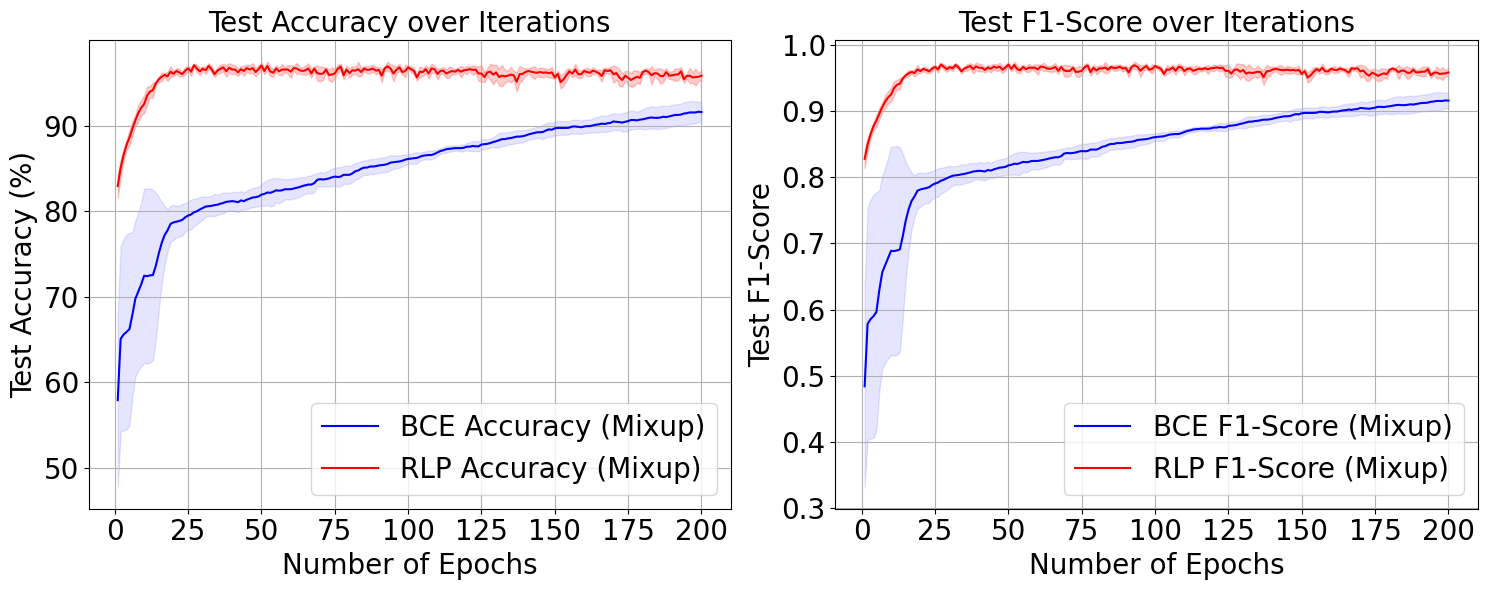

In [26]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy (Mixup)", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score (Mixup)", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
#plt.savefig("moons_rlp_bce.pdf", format="pdf", dpi=600)
plt.show()